# Questions 2.6 et 2.7 : Apprentissage Supervisé pour la Prédiction Bitcoin

Ce notebook implémente un **réseau de neurones supervisé** pour prédire la direction du prix du Bitcoin.

## Objectif
- **Question 2.6** : Entraîner un agent basé sur l'apprentissage supervisé pour classifier la direction du marché
- **Question 2.7** : Mesurer les performances en termes d'accuracy et temps d'entraînement

## Approche
Contrairement au DQN qui apprend par essai-erreur, ici nous utilisons un **réseau de neurones classique** avec des étiquettes pré-définies :
- **Classe 0** : Prix va **BAISSER** (rendement < -0.5%)
- **Classe 1** : Prix va **RESTER STABLE** (-0.5% ≤ rendement ≤ 0.5%)
- **Classe 2** : Prix va **MONTER** (rendement > 0.5%)

## 1. Importation des bibliothèques

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from ta.momentum import RSIIndicator
from ta.trend import MACD
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)

## 2. Chargement et Préparation des Données

Nous réutilisons les **mêmes données** que pour le DQN (Bitcoin 2018-2024) avec les mêmes indicateurs techniques.

In [5]:
def get_bitcoin_data():
    """
    Télécharge les données historiques Bitcoin et calcule les indicateurs techniques.
    Identique à la fonction utilisée dans le DQN.
    """
    print("Téléchargement des données Bitcoin...")
    df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
    
    # Correction du MultiIndex si nécessaire
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df = df.astype('float32')
    df = df.dropna()
    close_series = df['Close'].squeeze()

    # Calcul du rendement logarithmique
    df['log_ret'] = np.log(close_series / close_series.shift(1))
    
    # Indicateur RSI (Relative Strength Index)
    rsi = RSIIndicator(close=close_series, window=14)
    df['rsi'] = rsi.rsi() / 100.0  # Normalisation [0, 1]
    
    # Indicateur MACD (Moving Average Convergence Divergence)
    macd = MACD(close=close_series)
    df['macd'] = macd.macd_diff()
    
    # Calcul du rendement FUTUR (notre cible à prédire)
    df['future_return'] = df['log_ret'].shift(-1)  # Rendement du jour suivant
    
    df = df.dropna()
    df = df.astype('float32')
    
    print(f"Données prêtes : {len(df)} jours de trading.")
    return df

# Chargement des données
df = get_bitcoin_data()

Téléchargement des données Bitcoin...


C:\Users\leona\AppData\Local\Temp\ipykernel_37300\3977959834.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed

Données prêtes : 2157 jours de trading.


## 3. Création des Étiquettes (Labels) pour la Classification

Dans l'apprentissage supervisé, nous avons besoin d'**étiquettes** (labels) pour chaque observation.
Nous créons 3 classes basées sur le rendement futur :

- **Classe 0 (BAISSE)** : `future_return < -0.005` (-0.5%)
- **Classe 1 (STABLE)** : `-0.005 ≤ future_return ≤ 0.005`
- **Classe 2 (HAUSSE)** : `future_return > 0.005` (+0.5%)

In [6]:
def create_labels(df, threshold=0.005):
    """
    Crée les étiquettes de classification basées sur le rendement futur.
    
    Args:
        df: DataFrame contenant 'future_return'
        threshold: Seuil pour définir hausse/baisse (0.005 = 0.5%)
    
    Returns:
        df avec une colonne 'label' (0, 1, ou 2)
    """
    conditions = [
        df['future_return'] < -threshold,  # BAISSE
        (df['future_return'] >= -threshold) & (df['future_return'] <= threshold),  # STABLE
        df['future_return'] > threshold  # HAUSSE
    ]
    
    labels = [0, 1, 2]
    df['label'] = np.select(conditions, labels)
    
    # Statistiques des classes
    print("\nDistribution des classes :")
    print(df['label'].value_counts().sort_index())
    print(f"\n  0 = BAISSE ({(df['label'] == 0).sum()} jours, {100 * (df['label'] == 0).sum() / len(df):.1f}%)")
    print(f"  1 = STABLE ({(df['label'] == 1).sum()} jours, {100 * (df['label'] == 1).sum() / len(df):.1f}%)")
    print(f"  2 = HAUSSE ({(df['label'] == 2).sum()} jours, {100 * (df['label'] == 2).sum() / len(df):.1f}%)")
    
    return df

# Création des étiquettes
df = create_labels(df, threshold=0.005)


Distribution des classes :
label
0    811
1    473
2    873
Name: count, dtype: int64

  0 = BAISSE (811 jours, 37.6%)
  1 = STABLE (473 jours, 21.9%)
  2 = HAUSSE (873 jours, 40.5%)


## 4. Préparation des Features (X) et Labels (y)

Nous utilisons les **mêmes features** que le DQN :
- `log_ret` : Rendement logarithmique actuel
- `rsi` : Indicateur RSI normalisé
- `macd` : Indicateur MACD

Contrairement au DQN, nous n'incluons pas la position actuelle ni le solde (car c'est une prédiction pure, pas une gestion de portefeuille).

In [7]:
# Sélection des features (entrées du réseau)
feature_columns = ['log_ret', 'rsi', 'macd']
X = df[feature_columns].values
y = df['label'].values

print(f"\nDimensions des données :")
print(f"  Features (X) : {X.shape}")
print(f"  Labels (y)   : {y.shape}")
print(f"\nAperçu des 5 premières observations :")
print(pd.DataFrame(X[:5], columns=feature_columns))
print(f"Labels correspondants : {y[:5]}")


Dimensions des données :
  Features (X) : (2157, 3)
  Labels (y)   : (2157,)

Aperçu des 5 premières observations :
    log_ret       rsi        macd
0  0.038233  0.322394 -163.009064
1 -0.102991  0.284253 -201.033722
2 -0.173982  0.239361 -289.724274
3  0.108709  0.310252 -269.538116
4 -0.017262  0.305163 -240.995743
Labels correspondants : [0 0 2 0 2]


## 5. Séparation Train/Test

Pour l'apprentissage supervisé, nous divisons les données en :
- **80% pour l'entraînement** (apprendre les patterns)
- **20% pour le test** (évaluer la généralisation)

In [8]:
# Séparation temporelle (important pour les séries temporelles)
# On prend les 80% premiers jours pour l'entraînement, 20% derniers pour le test
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nSéparation des données :")
print(f"  Ensemble d'entraînement : {X_train.shape[0]} jours ({100 * X_train.shape[0] / len(X):.0f}%)")
print(f"  Ensemble de test        : {X_test.shape[0]} jours ({100 * X_test.shape[0] / len(X):.0f}%)")

# Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Création des DataLoaders pour l'entraînement par batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"\nDataLoaders créés avec batch_size=64")


Séparation des données :
  Ensemble d'entraînement : 1725 jours (80%)
  Ensemble de test        : 432 jours (20%)

DataLoaders créés avec batch_size=64


## 6. Architecture du Réseau de Neurones Supervisé

Nous utilisons une architecture **similaire au DQN** pour permettre une comparaison équitable :
- **Couche d'entrée** : 3 neurones (log_ret, rsi, macd)
- **Couche cachée 1** : 64 neurones + ReLU
- **Couche cachée 2** : 32 neurones + ReLU
- **Couche de sortie** : 3 neurones (probabilités pour chaque classe)

**Différence clé avec le DQN** : La sortie représente des **probabilités de classe** (via Softmax), pas des Q-values.

In [9]:
class SupervisedNN(nn.Module):
    """
    Réseau de Neurones pour la Classification Supervisée.
    Architecture : 3 -> 64 -> 32 -> 3
    """
    def __init__(self, input_dim=3, output_dim=3):
        super(SupervisedNN, self).__init__()
        
        # Couches entièrement connectées
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
        # Fonctions d'activation
        self.relu = nn.ReLU()
        # Note: Pas besoin de Softmax car CrossEntropyLoss l'applique automatiquement
    
    def forward(self, x):
        """
        Propagation avant (Forward pass).
        
        Args:
            x: Tensor de features [batch_size, 3]
        
        Returns:
            Tensor de logits [batch_size, 3] (scores non normalisés)
        """
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Sortie linéaire (logits)
        return x

# Instanciation du modèle
model = SupervisedNN(input_dim=3, output_dim=3)
print("\nArchitecture du réseau :")
print(model)
print(f"\nNombre total de paramètres : {sum(p.numel() for p in model.parameters())}")


Architecture du réseau :
SupervisedNN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Nombre total de paramètres : 2435


## 7. Configuration de l'Entraînement

- **Fonction de perte** : `CrossEntropyLoss` (standard pour la classification multi-classe)
- **Optimiseur** : `Adam` avec learning rate = 0.001 (identique au DQN)
- **Nombre d'époques** : 100 (pour comparaison avec les 100 épisodes du DQN)

In [10]:
# Hyperparamètres
EPOCHS = 100
LEARNING_RATE = 0.001

# Fonction de perte : Cross-Entropy (standard pour classification)
criterion = nn.CrossEntropyLoss()

# Optimiseur : Adam (identique au DQN)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Configuration de l'entraînement :")
print(f"  Nombre d'époques : {EPOCHS}")
print(f"  Learning rate    : {LEARNING_RATE}")
print(f"  Fonction de perte: CrossEntropyLoss")
print(f"  Optimiseur       : Adam")

Configuration de l'entraînement :
  Nombre d'époques : 100
  Learning rate    : 0.001
  Fonction de perte: CrossEntropyLoss
  Optimiseur       : Adam


## 8. Boucle d'Entraînement (Question 2.6)

Nous entraînons le modèle sur 100 époques et suivons :
- La **perte** (loss) sur l'ensemble d'entraînement
- L'**accuracy** sur l'ensemble de test
- Le **temps d'entraînement** total

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    """
    Entraîne le modèle supervisé et évalue ses performances.
    
    Args:
        model: Modèle à entraîner
        train_loader: DataLoader d'entraînement
        test_loader: DataLoader de test
        criterion: Fonction de perte
        optimizer: Optimiseur
        epochs: Nombre d'époques
    
    Returns:
        history: Dictionnaire contenant l'historique d'entraînement
        training_time: Temps d'entraînement en secondes
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_accuracy': []
    }
    
    print("\nDébut de l'entraînement...\n")
    start_time = time.time()
    
    for epoch in range(epochs):
        # === PHASE D'ENTRAÎNEMENT ===
        model.train()  # Mode entraînement
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_X, batch_y in train_loader:
            # Réinitialisation des gradients
            optimizer.zero_grad()
            
            # Prédiction (Forward pass)
            outputs = model(batch_X)
            
            # Calcul de la perte
            loss = criterion(outputs, batch_y)
            
            # Rétropropagation (Backward pass)
            loss.backward()
            
            # Mise à jour des poids
            optimizer.step()
            
            # Statistiques
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()
        
        # Moyennes pour cette époque
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # === PHASE D'ÉVALUATION (TEST) ===
        model.eval()  # Mode évaluation
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():  # Pas de calcul de gradient pour le test
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                total_test += batch_y.size(0)
                correct_test += (predicted == batch_y).sum().item()
        
        test_accuracy = 100 * correct_test / total_test
        
        # Enregistrement de l'historique
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['test_accuracy'].append(test_accuracy)
        
        # Affichage tous les 5 époques
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Époque [{epoch+1:3d}/{epochs}] | "
                  f"Loss: {avg_train_loss:.4f} | "
                  f"Train Acc: {train_accuracy:.2f}% | "
                  f"Test Acc: {test_accuracy:.2f}%")
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nEntraînement terminé en {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
    
    return history, training_time

# Lancement de l'entraînement
history, training_time = train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS)


Début de l'entraînement...

Époque [  1/100] | Loss: 3.4617 | Train Acc: 36.87% | Test Acc: 36.34%
Époque [  5/100] | Loss: 1.1072 | Train Acc: 40.12% | Test Acc: 34.95%
Époque [ 10/100] | Loss: 1.3054 | Train Acc: 40.93% | Test Acc: 33.80%
Époque [ 15/100] | Loss: 1.1159 | Train Acc: 40.64% | Test Acc: 31.94%
Époque [ 20/100] | Loss: 1.1699 | Train Acc: 40.99% | Test Acc: 33.80%
Époque [ 25/100] | Loss: 1.1035 | Train Acc: 40.52% | Test Acc: 32.64%
Époque [ 30/100] | Loss: 1.1182 | Train Acc: 40.64% | Test Acc: 33.80%
Époque [ 35/100] | Loss: 1.0741 | Train Acc: 42.55% | Test Acc: 31.71%
Époque [ 40/100] | Loss: 1.1252 | Train Acc: 40.17% | Test Acc: 34.26%
Époque [ 45/100] | Loss: 1.0838 | Train Acc: 41.68% | Test Acc: 33.56%
Époque [ 50/100] | Loss: 1.0979 | Train Acc: 40.99% | Test Acc: 33.56%
Époque [ 55/100] | Loss: 1.0662 | Train Acc: 40.87% | Test Acc: 33.10%
Époque [ 60/100] | Loss: 1.0841 | Train Acc: 42.09% | Test Acc: 34.03%
Époque [ 65/100] | Loss: 1.0602 | Train Acc: 42.

## 9. Évaluation Finale et Métriques (Question 2.7)

Nous calculons les métriques de performance sur l'ensemble de test :
- **Accuracy globale** (exactitude)
- **Matrice de confusion**
- **Rapport de classification** (précision, rappel, F1-score par classe)
- **Temps d'entraînement**

In [12]:
def evaluate_model(model, X_test, y_test):
    """
    Évalue le modèle final sur l'ensemble de test.
    
    Args:
        model: Modèle entraîné
        X_test: Features de test
        y_test: Labels de test
    
    Returns:
        predictions: Prédictions du modèle
        accuracy: Accuracy finale
    """
    model.eval()
    
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)
        predictions = predictions.numpy()
    
    accuracy = accuracy_score(y_test, predictions)
    
    print("\n" + "="*60)
    print("RÉSULTATS FINAUX - QUESTION 2.7")
    print("="*60)
    
    print(f"\nAccuracy (Exactitude) : {accuracy*100:.2f}%")
    print(f"Temps d'entraînement : {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
    
    # Matrice de confusion
    print("\nMatrice de Confusion :")
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    print("\n(Lignes = Vraies classes, Colonnes = Prédictions)")
    print("  0 = BAISSE, 1 = STABLE, 2 = HAUSSE")
    
    # Rapport de classification détaillé
    print("\nRapport de Classification Détaillé :")
    target_names = ['BAISSE (0)', 'STABLE (1)', 'HAUSSE (2)']
    print(classification_report(y_test, predictions, target_names=target_names))
    
    return predictions, accuracy

# Évaluation finale
predictions, final_accuracy = evaluate_model(model, X_test_tensor, y_test)


RÉSULTATS FINAUX - QUESTION 2.7

Accuracy (Exactitude) : 32.64%
Temps d'entraînement : 14.39 secondes (0.24 minutes)

Matrice de Confusion :
[[63  1 71]
 [61  0 90]
 [68  0 78]]

(Lignes = Vraies classes, Colonnes = Prédictions)
  0 = BAISSE, 1 = STABLE, 2 = HAUSSE

Rapport de Classification Détaillé :
              precision    recall  f1-score   support

  BAISSE (0)       0.33      0.47      0.39       135
  STABLE (1)       0.00      0.00      0.00       151
  HAUSSE (2)       0.33      0.53      0.41       146

    accuracy                           0.33       432
   macro avg       0.22      0.33      0.26       432
weighted avg       0.21      0.33      0.26       432



## 10. Visualisation des Résultats

Nous créons plusieurs graphiques pour analyser les performances :
1. **Courbe d'apprentissage** (Loss + Accuracy au fil des époques)
2. **Matrice de confusion** (heatmap)
3. **Comparaison Train vs Test Accuracy**

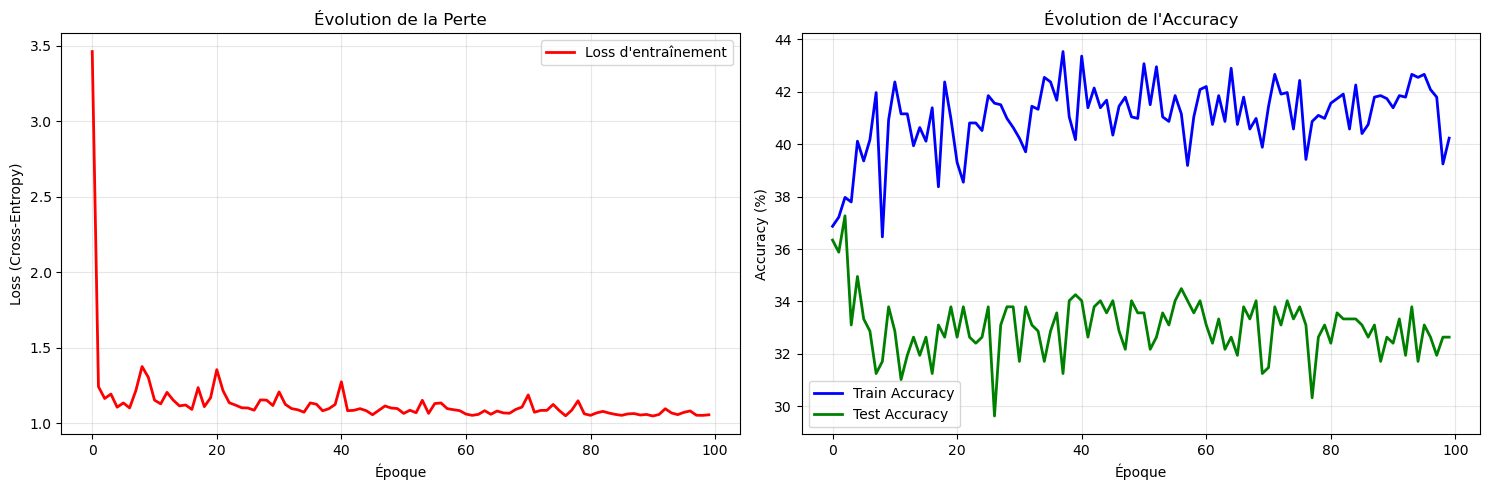

Graphique sauvegardé : supervised_learning_curves.png


In [13]:
# === GRAPHIQUE 1 : Courbe d'Apprentissage ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Sous-graphique 1 : Loss
ax1.plot(history['train_loss'], label='Loss d\'entraînement', color='red', linewidth=2)
ax1.set_xlabel('Époque')
ax1.set_ylabel('Loss (Cross-Entropy)')
ax1.set_title('Évolution de la Perte')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sous-graphique 2 : Accuracy
ax2.plot(history['train_accuracy'], label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(history['test_accuracy'], label='Test Accuracy', color='green', linewidth=2)
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Évolution de l\'Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('supervised_learning_curves.png', dpi=300)
plt.show()

print("Graphique sauvegardé : supervised_learning_curves.png")

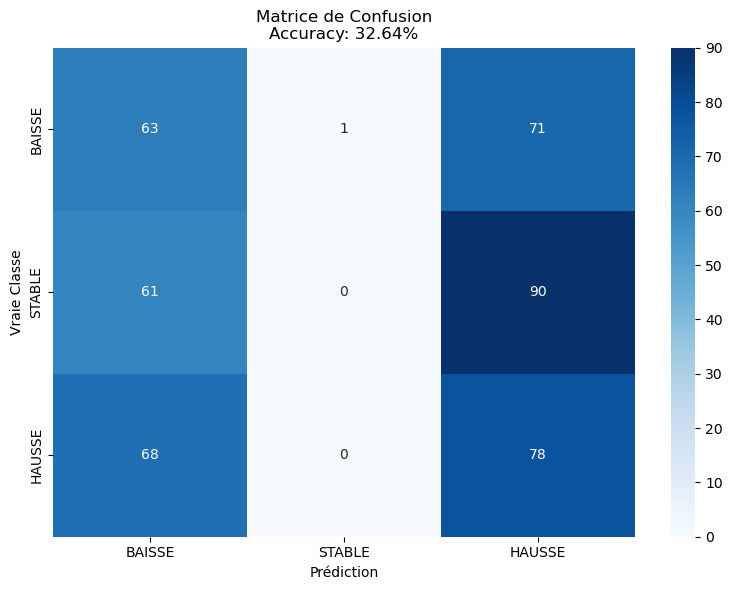

Graphique sauvegardé : confusion_matrix.png


In [14]:
# === GRAPHIQUE 2 : Matrice de Confusion (Heatmap) ===
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['BAISSE', 'STABLE', 'HAUSSE'],
            yticklabels=['BAISSE', 'STABLE', 'HAUSSE'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Classe')
plt.title(f'Matrice de Confusion\nAccuracy: {final_accuracy*100:.2f}%')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

print("Graphique sauvegardé : confusion_matrix.png")

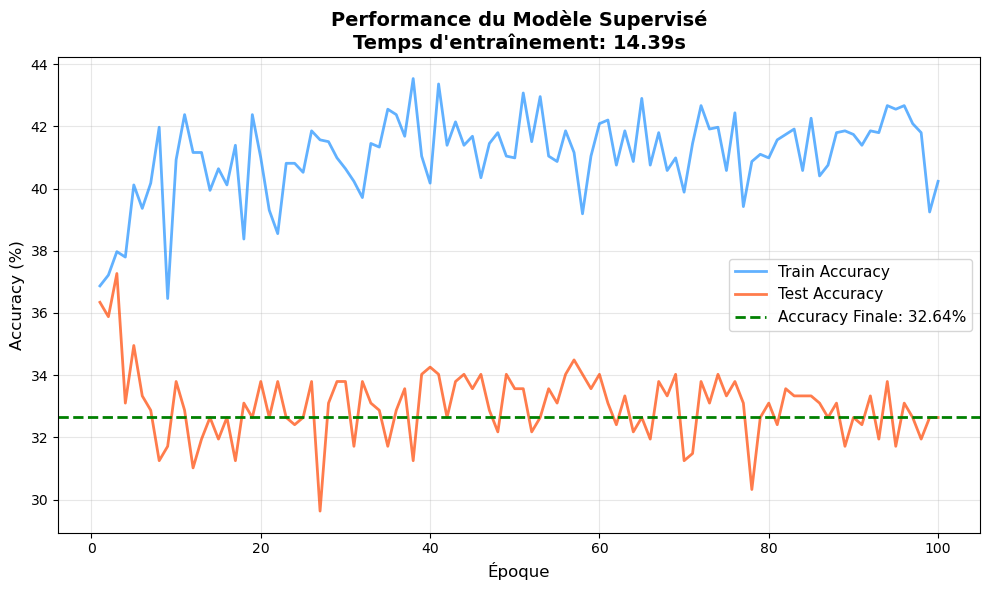

Graphique sauvegardé : supervised_performance.png


In [15]:
# === GRAPHIQUE 3 : Comparaison Finale ===
plt.figure(figsize=(10, 6))

epochs_range = range(1, EPOCHS + 1)
plt.plot(epochs_range, history['train_accuracy'], label='Train Accuracy', 
         color='dodgerblue', linewidth=2, alpha=0.7)
plt.plot(epochs_range, history['test_accuracy'], label='Test Accuracy', 
         color='orangered', linewidth=2, alpha=0.7)

# Ligne horizontale pour l'accuracy finale
plt.axhline(y=final_accuracy*100, color='green', linestyle='--', 
            linewidth=2, label=f'Accuracy Finale: {final_accuracy*100:.2f}%')

plt.xlabel('Époque', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Performance du Modèle Supervisé\nTemps d\'entraînement: {training_time:.2f}s', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('supervised_performance.png', dpi=300)
plt.show()

print("Graphique sauvegardé : supervised_performance.png")

## 11. Analyse des Erreurs

Analysons où le modèle fait des erreurs pour mieux comprendre ses limites.

In [16]:
# Identifier les erreurs de classification
errors = predictions != y_test
error_indices = np.where(errors)[0]

print(f"\nNombre d'erreurs : {len(error_indices)} / {len(y_test)} ({100*len(error_indices)/len(y_test):.2f}%)")
print(f"Nombre de prédictions correctes : {len(y_test) - len(error_indices)} / {len(y_test)}")

# Analyse des types d'erreurs
print("\nTypes d'erreurs :")
for true_class in [0, 1, 2]:
    class_name = ['BAISSE', 'STABLE', 'HAUSSE'][true_class]
    true_class_mask = y_test == true_class
    errors_in_class = errors & true_class_mask
    
    if true_class_mask.sum() > 0:
        error_rate = 100 * errors_in_class.sum() / true_class_mask.sum()
        print(f"  Classe {true_class} ({class_name:7s}) : {error_rate:.1f}% d'erreurs")


Nombre d'erreurs : 291 / 432 (67.36%)
Nombre de prédictions correctes : 141 / 432

Types d'erreurs :
  Classe 0 (BAISSE ) : 53.3% d'erreurs
  Classe 1 (STABLE ) : 100.0% d'erreurs
  Classe 2 (HAUSSE ) : 46.6% d'erreurs


## 12. Sauvegarde du Modèle

Nous sauvegardons le modèle entraîné pour pouvoir le réutiliser dans la question 2.8 (comparaison avec DQN).

In [17]:
# Sauvegarde du modèle
torch.save(model.state_dict(), 'supervised_bitcoin_model.pth')
print("\nModèle sauvegardé : supervised_bitcoin_model.pth")

# Sauvegarde des résultats pour le rapport
results = {
    'accuracy': final_accuracy,
    'training_time': training_time,
    'history': history
}

import pickle
with open('supervised_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Résultats sauvegardés : supervised_results.pkl")


Modèle sauvegardé : supervised_bitcoin_model.pth
Résultats sauvegardés : supervised_results.pkl
